### Sentinel 5P and Xarray
This notebook is all about reading Sentinel 5P data into xarray and plotting. It is a continuation of a another Sentinel5P Python notebook I wrote about here https://github.com/acgeospatial/Sentinel-5P/blob/master/Sentinel_5P.ipynb

You can install xarray via conda here https://anaconda.org/anaconda/xarray (this is what I have done)

Download a Sentinel5P dataset(s) from the copernicus scihub https://s5phub.copernicus.eu/dhus/ 

In [1]:
import xarray as xr # import xarray

The strange thing about this post is I got stuck on the next line... reading in the data to xarray. Whatever I did could not read the netcdf file in

In [2]:
data5p = xr.open_dataset('S5P_NRTI_L2__NO2____20190608T133339_20190608T133839_08557_01_010301_20190608T140849.nc')
print(data5p)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    Conventions:                        CF-1.7
    institution:                        KNMI
    source:                             Sentinel 5 precursor, TROPOMI, space-...
    history:                            2019-06-08 14:11:11 f_s5pops tropnll2...
    summary:                            TROPOMI/S5P NO2 1-Orbit L2 Swath 7x3.5km
    tracking_id:                        44d4141b-be9d-4dd0-8b5a-981b3ff4b234
    id:                                 S5P_NRTI_L2__NO2____20190608T133339_2...
    time_reference:                     2019-06-08T00:00:00Z
    time_reference_days_since_1950:     25360
    time_reference_julian_day:          2458642.5
    time_reference_seconds_since_1970:  1559952000
    time_coverage_start:                2019-06-08T13:33:34Z
    time_coverage_end:                  2019-06-08T13:38:46Z
    time_coverage_duration:             PT312.113S
    time_coverage_resolution:           PT1.080S
    

I was stuck here. Look at the dimensions - my data has no dimensions! which seems very odd to me. <br>

this code... <br> <br>
xr.open_dataarray('S5P_NRTI_L2__NO2____20190608T133339_20190608T133839_08557_01_010301_20190608T140849.nc')


#### Is not going to work <br>
try it yourself...

It was a while before I remembered that these Sentinel5P data sets are set up in groups. http://docs.h5py.org/en/stable/high/group.html
<br>    
I therefored needed to find the group!, but how?

I found the answer but using the netcdf library and looking for the groups. See 

https://github.com/acgeospatial/Sentinel-5P/blob/master/Sentinel_5P.ipynb
    
In[6] print (fh.groups) <br>

and then <br>



In[7] print (fh.groups['PRODUCT'])





In [3]:
data5p = xr.open_dataset('S5P_NRTI_L2__NO2____20190608T133339_20190608T133839_08557_01_010301_20190608T140849.nc', group='PRODUCT')
print(data5p)

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 290, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 0.0 ... 289.0
  * ground_pixel                                          (ground_pixel) float64 0.0 ... 449.0
  * time                                                  (time) datetime64[ns] 2019-06-08
  * corner                                                (corner) float64 0.0 ... 3.0
  * polynomial_exponents                                  (polynomial_exponents) float64 0.0 ... 5.0
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 0.0
  * layer                                                 (layer) float64 0.0 ... 33.0
  * vertices                                              (vertices) float64 0.0 1.0
    latitude       

We now have dimensions!

In [4]:
## get the data for N02
no2 = (data5p['nitrogendioxide_tropospheric_column_precision'])
print(no2)

<xarray.DataArray 'nitrogendioxide_tropospheric_column_precision' (time: 1, scanline: 290, ground_pixel: 450)>
[130500 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 286.0 287.0 288.0 289.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2019-06-08
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             Precision of the t...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19


Previously I used this method to extract the data and plot

In [5]:
no2_data = data5p['nitrogendioxide_tropospheric_column_precision'][0,:,:]
print(no2_data.shape)

(290, 450)


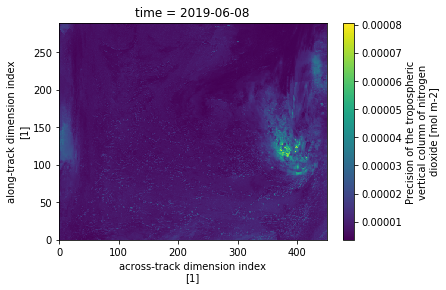

In [6]:
%matplotlib inline
no2_data.plot()

Which is great apart from I want to get the along-track dimension index to be latitude and the across-track dimension to be longitude

In [7]:
## in xarray thee lat and long are associated to the cube of data, so I should able to access them this way
print(data5p.latitude.attrs)
print(data5p.longitude.attrs)

OrderedDict([('long_name', 'pixel center latitude'), ('units', 'degrees_north'), ('standard_name', 'latitude'), ('valid_min', -90.0), ('valid_max', 90.0), ('bounds', '/PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds')])
OrderedDict([('long_name', 'pixel center longitude'), ('units', 'degrees_east'), ('standard_name', 'longitude'), ('valid_min', -180.0), ('valid_max', 180.0), ('bounds', '/PRODUCT/SUPPORT_DATA/GEOLOCATIONS/longitude_bounds')])


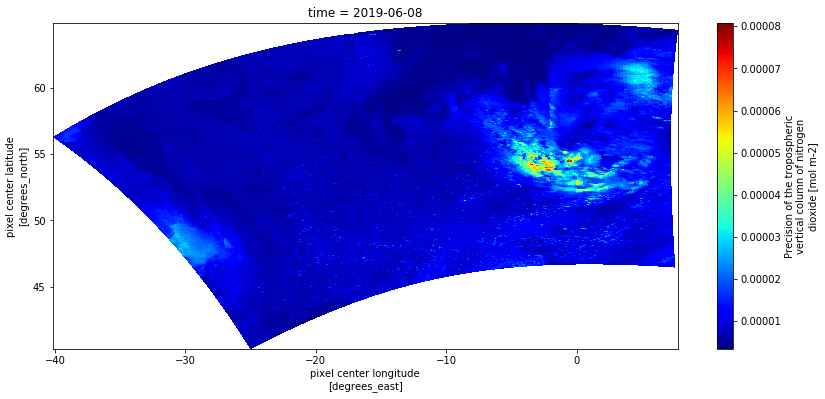

In [8]:
#https://github.com/pydata/xarray/blob/master/examples/xarray_multidimensional_coords.ipynb
from matplotlib import pyplot as plt
plt.figure(figsize=(14,6))
ax = plt.axes()


data5p.nitrogendioxide_tropospheric_column_precision[0].plot.pcolormesh \
(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet')

We can use cartopy (as basemap is being discontinued) to plot the location of the data on the globe

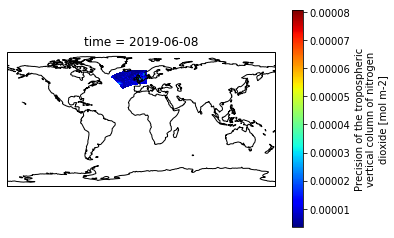

In [9]:
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())


data5p.nitrogendioxide_tropospheric_column_precision[0].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet')


ax.set_global(); ax.coastlines()

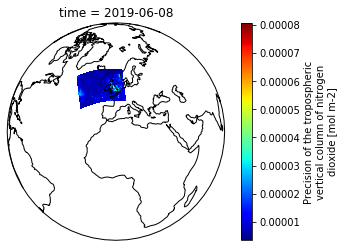

In [10]:
ax = plt.axes(projection=ccrs.Orthographic(0, 30))


data5p.nitrogendioxide_tropospheric_column_precision[0].plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='jet', transform=ccrs.PlateCarree())


ax.set_global(); ax.coastlines()